In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Convert MINIST Images to Tensors

In [3]:
transform = transforms.ToTensor()

In [4]:
train_data = datasets.MNIST(root='Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='Data', train=False, download=True, transform=transform)

C:\Users\shisk\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
image, label = train_data[0]

In [8]:
image.shape

torch.Size([1, 28, 28])

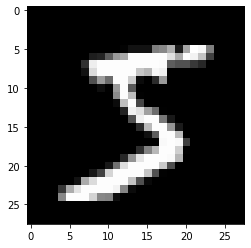

In [9]:
plt.imshow(image.reshape(image.shape[1:]), cmap = 'gray')

In [10]:
label

5

In [11]:
torch.manual_seed(101)

# convert data nto batches
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [12]:
from torchvision.utils import make_grid

np.set_printoptions(formatter=dict(int=lambda x:f'{x:4}')) # formatting

In [13]:
len(train_loader)

600

In [14]:
# getting the first batch
'''
the train_loader is similar to an iterable object that when called returns one batch of image as a time
so breaking instantly gives us single batch of the images
'''
for images, labels in train_loader:
    break

In [15]:
images.shape

torch.Size([100, 1, 28, 28])

In [16]:
labels.shape

torch.Size([100])

Label: [   7    2    3    5    8    5    3    6    9    9    1    3    5    5]


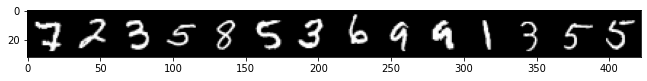

In [17]:
# print labels
print('Label:', labels[:14].numpy())

# print the first 114 images
im = make_grid(images[:14], nrow=14)  # the default nrow is 8
plt.figure(figsize=(11,5))
# We need to transpose the images from CWH to WHC as matplotlib takes no. of channels as the last argument in shape
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Artifical Neural Network

In [18]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120, 84]):  # layers corresponds to the hddden layer units
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)
        
    # X is the unput data    
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        # softmax for multiclass classification
        return F.log_softmax(X, dim=1)

In [19]:
torch.manual_seed(101)

In [20]:
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [21]:
total_params = 0
for param in model.parameters():
    total_params+=param.numel()
print(total_params)

105214


### Define Loss and Optimizer

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)  # lr = learning rate

In [23]:
# flattening the last 3 dimensons
images.view(100, -1).shape

torch.Size([100, 784])

In [24]:
import time

### Training

In [25]:
# track time
start_time = time.time()

epochs = 5

# save results for visualization
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for batch_n, (X_train, y_train) in enumerate(train_loader):
        batch_n+=1
        
        # get predictions
        y_pred = model(X_train.view(100,-1))    # flatten and feed data
        
        # get loss
        loss = criterion(y_pred, y_train)
        
        # get all predicted class
        y_pred_class = torch.max(y_pred.data, 1)[1]  # maximum val of softmax transformation
        batch_corr = (y_pred_class == y_train).sum() # total correct predictions for batch
        trn_corr+=batch_corr                       # add to total correct for tiven epoch
        
    
        optimizer.zero_grad()     # clear gradients since this is a new batch
        loss.backward()           # calculate gradients for given batch loss
        optimizer.step()          # apply gradients and update parameters
        
        # print accuracy after 20 batches
        if batch_n%200 == 0:
            acc = trn_corr.item()*100/(100*batch_n)
            print(f'Epoch {i:2} batch{batch_n:4}  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*batch_n):7.3f}%')
    
    # save train loss and acc after each epoch
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())
    
    with torch.no_grad(): # no_grad() makes sure the weights aren't updated
        for batch_n, (X_test, y_test) in enumerate(test_loader):
            
            y_test_pred = model(X_test.view(500, -1))    # get predictions on test data
            y_pred_test_class = torch.max(y_test_pred.data, 1)[1]
            
            tst_corr += (y_pred_test_class == y_test).sum()
    
    # save test loss after each epoch
    tst_loss = criterion(y_test_pred, y_test)
    test_losses.append(tst_loss)
    test_correct.append(tst_corr)
          
total_time = time.time() - start_time
print(f'Duration: {total_time/60} mins')

Epoch  0 batch 200  loss: 0.23562382  accuracy:  83.245%
Epoch  0 batch 400  loss: 0.35328561  accuracy:  87.532%
Epoch  0 batch 600  loss: 0.13676643  accuracy:  89.578%
Epoch  1 batch 200  loss: 0.24834305  accuracy:  94.855%
Epoch  1 batch 400  loss: 0.14312378  accuracy:  95.082%
Epoch  1 batch 600  loss: 0.07554840  accuracy:  95.348%
Epoch  2 batch 200  loss: 0.08443388  accuracy:  96.575%
Epoch  2 batch 400  loss: 0.06208451  accuracy:  96.635%
Epoch  2 batch 600  loss: 0.06475770  accuracy:  96.717%
Epoch  3 batch 200  loss: 0.11909937  accuracy:  97.675%
Epoch  3 batch 400  loss: 0.05785089  accuracy:  97.513%
Epoch  3 batch 600  loss: 0.03136251  accuracy:  97.520%
Epoch  4 batch 200  loss: 0.10836449  accuracy:  98.180%
Epoch  4 batch 400  loss: 0.04291663  accuracy:  98.002%
Epoch  4 batch 600  loss: 0.05244940  accuracy:  98.027%
Duration: 2.71025664806366 mins


### Evaluation

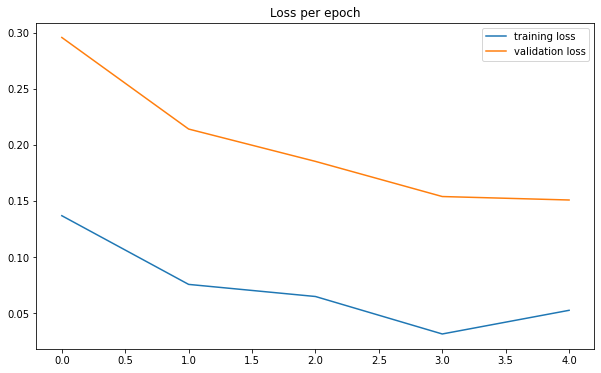

In [26]:
plt.figure(figsize = (10, 6))
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss per epoch')
plt.legend();

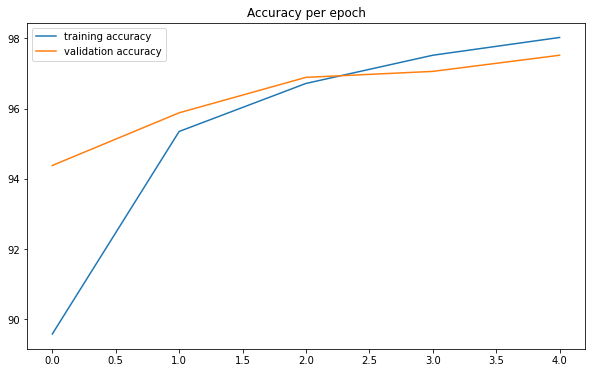

In [27]:
plt.figure(figsize = (10, 6))
'''
train_correct and test_correct contain the number of correct predictions for each epoch; however, as training and test 
have different number of samples per epoch, we divide by no of batches.
'''
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy per epoch')
plt.legend();

In [28]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [29]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9752/10000 =  97.520%


In [30]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 969    0    5    0    1    2    4    1    6    3]
 [   0 1124    3    0    0    0    3    8    1    4]
 [   0    3 1000    2    3    0    1    8    2    0]
 [   2    2    5  991    0   10    1    4   10    7]
 [   2    0    2    0  956    2    3    0    4   12]
 [   1    1    0    7    1  869    4    2    7    3]
 [   1    2    5    0    4    5  941    0    3    0]
 [   1    0    6    6    2    1    0 1000    4    9]
 [   2    3    6    3    2    1    1    0  935    4]
 [   2    0    0    1   13    2    0    5    2  967]]
